In [580]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import json
import requests
from PIL import Image
from io import BytesIO
import numpy as np  
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import average_precision_score

In [581]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

<h3><i>Download images</i></h3>

In [582]:
df = pd.read_csv('pizza_data_final.csv', index_col='id')

C:\Users\TTG\AppData\Local\Temp\ipykernel_3408\1234846730.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('pizza_data_final.csv', index_col='id')


In [583]:
all_error_list = ['Bánh không tròn | Distorted shape',
 'Cháy | Baking - Burnt',
 'Viền k đều | Edge - Uneven',
 'Bánh bé | Size - Too small',
 'Thiếu bóng | too few balls',
 'Không đốm | Baking - Does not have leopard-spotting',
 'Màu nhạt | Baking - Pale',
 'Viền nhỏ | Edge - Too small',
 'Viền to | Edge - Too big',
 'Nở viền không đủ | edge pizza is not enough swollen',
 'Viền thấp | Edge - Too low',
 'Phô mai cao | Topping - Cheese too high * with a core*',
 'Topping - Không đúng | incorrect portioning',
 'Không cân Topping - Not even half and half',
 'Sốt trên mép | Topping - Sauce covering on the edge',
 'Lên men thiếu | Fermentation - Lack fermentation',
 'Quá theo viền | Topping - Too strong shaping the edge',
 'Trộn lẫn | Topping - Bended',
 'Quá tập trung | Topping - Topping too centered',
 'Topping - Không đều | Not even',
 'Lên men quá nhiều | Fermentation - Over fermentation',
 'Không hình tròn | Topping - Not circled',
 'Bánh lớn | Size - Too big']
# tổng cộng có 23 loại lỗi

In [584]:
queue_download_image = []    # lưu danh sách các ảnh cần tải để bỏ vào dataset
seen = set()
for error in all_error_list:
    error_df = df[df[error] == 1].head(1000)
    for image_id, image_url in zip(error_df.index, error_df['image_url']):
        if (image_id, image_url) not in seen:
            queue_download_image.append((image_id, image_url))
            seen.add((image_id, image_url))
len(queue_download_image)

11519

In [585]:
# # Download
# data_path = 'data/pizza_image'
# downloaded = []
# for id, url in tqdm(queue_download_image):
#     if id not in downloaded:
#         downloaded.append(id)
#         response = requests.get(url)
#         image_data = BytesIO(response.content)
#         image = Image.open(image_data)
#         image_file_name = os.path.join(data_path, f"{id}.jpg")
#         image.save(image_file_name)
#         if response.status_code == 200:
#             pass
#         else:
#             print(f"Failed to download {image_url}")

In [586]:
dict_labels = {}   # lưu nhãn theo dạng [0, 1, 0, 1, 1, 0, 0, 0, ...]
for id, _ in tqdm(queue_download_image):
    dict_labels[id] = []
    for error in all_error_list:
        dict_labels[id].append(df.at[id, error])

100%|██████████| 11519/11519 [00:00<00:00, 16694.20it/s]


In [587]:
# transfer learning, chọn pretrained model ResNet-50 và thay đổi lớp fully connected cuối, đồng thời đóng băng tham số của tất cả layer trừ layer 4 và layer fc
model = torchvision.models.resnet50(pretrained = True)
num_classes = 20
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes),
    nn.Sigmoid()
)

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
    
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Số tham số có thể học được (không bị đóng băng): {total_params}")

c:\Users\TTG\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TTG\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Số tham số có thể học được (không bị đóng băng): 16024084


In [588]:
# chuẩn bị image_paths, labels
path_to_image = 'data/pizza_image/'
image_paths = []
labels = []
for id, _ in tqdm(queue_download_image):
    image_paths.append(path_to_image + f'{id}.jpg')
    labels.append(torch.tensor(dict_labels[id], dtype = torch.float))

  0%|          | 0/11519 [00:00<?, ?it/s]

100%|██████████| 11519/11519 [00:00<00:00, 179988.03it/s]


In [589]:
labels_combined = torch.cat([label.unsqueeze(0) for label in labels], dim=0)
print(labels_combined.shape)
label_counts = torch.sum(labels_combined, dim=0)
for i in range(23):
    print(i, label_counts[i])

torch.Size([11519, 23])
0 tensor(7580.)
1 tensor(3639.)
2 tensor(2686.)
3 tensor(2542.)
4 tensor(4026.)
5 tensor(3369.)
6 tensor(3426.)
7 tensor(3153.)
8 tensor(3322.)
9 tensor(2032.)
10 tensor(1107.)
11 tensor(1760.)
12 tensor(1151.)
13 tensor(1555.)
14 tensor(1334.)
15 tensor(1007.)
16 tensor(1041.)
17 tensor(1003.)
18 tensor(989.)
19 tensor(1013.)
20 tensor(40.)
21 tensor(5.)
22 tensor(81.)


<h4>==>  Kết luận: 3 nhãn cuối có lượng samples rất ít nên cân nhắc bỏ luôn và điều chỉnh để tính loss, đánh giá AP</h4>

In [590]:
labels = [label_tensor[:20] for label_tensor in labels]    # bỏ 3 nhãn cuối
len(labels)

11519

In [591]:
transform = transforms.Compose([    # hàm để biến đổi, chuẩn hóa ảnh và đưa về tensor
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [592]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transforms = None):
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        if self.transforms:
            image = self.transforms(image)
        return image, label

In [593]:
dataset = CustomImageDataset(image_paths=image_paths, labels=labels, transforms=transform)
dataset_len = len(dataset)
train_len = int(0.8 * dataset_len)
test_len = dataset_len - train_len
train_data, test_data = random_split(dataset, [train_len, test_len])

train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 64, shuffle = False)
print("Kích thước của train_data:", len(train_data), train_data[0][0].shape, train_data[0][1].shape)
print("Tổng số batch:", len(test_loader))

Kích thước của train_data: 9215 torch.Size([3, 224, 224]) torch.Size([20])
Tổng số batch: 36


In [594]:
# tính trọng số cho hàm loss
count_labels = np.array([7580, 3639, 2686, 2542, 4026, 3369, 3426, 3153, 3322, 2032, 1107, 1760, 1151, 1555, 1334, 1007, 1041, 1003, 989, 1013])
weights = 1.0 / count_labels
normalized_weights = weights / np.sum(weights)
normalized_weights = torch.tensor(normalized_weights)

In [595]:
loss_fn = nn.BCELoss(weight=normalized_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def calculate_mAP(y_pred, y_true):
    AP_scores = [average_precision_score(y_true[:, i], y_pred[:, i]) for i in range(20)]
    mAP_score = np.mean(AP_scores)
    return mAP_score, AP_scores

In [597]:
# Huấn luyện mô hình
num_epochs = 5
best_loss = 1000
train_loss_list = []
test_loss_list = []
train_mAP_list = []
test_mAP_list = []
for epoch in range(num_epochs):
    model.train()
    prediction_labels = []
    true_labels = []
    train_loss = 0
    for inputs, label in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        prediction_labels.extend(outputs.detach().numpy())
        true_labels.extend(label.detach().numpy())
    train_loss /= len(train_loader)
    prediction_labels = np.vstack(prediction_labels)
    true_labels  = np.vstack(true_labels)
    train_mAP, train_AP = calculate_mAP(prediction_labels, true_labels)
    train_loss_list.append(train_loss)
    train_mAP_list.append(train_mAP)
    # Đánh giá mô hình
    prediction_labels = []
    true_labels = []
    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for inputs, label in test_loader:
            outputs = model(inputs)
            predicted = torch.round(outputs)
            loss = loss_fn(outputs, label)
            test_loss += loss.item()
            prediction_labels.extend(outputs.detach().numpy())
            true_labels.extend(label.detach().numpy())
        test_loss /= len(test_loader)
        prediction_labels = np.vstack(prediction_labels)
        true_labels  = np.vstack(true_labels)
        test_mAP, test_AP = calculate_mAP(prediction_labels, true_labels)
        test_loss_list.append(test_loss)
        test_mAP_list.append(test_mAP)
    print(f'Epoch {epoch + 1}/{num_epochs}:')
    print(f'train_loss= {train_loss:.5f}, test_loss= {test_loss:.5f}')
    print(f'train_mAP= {train_mAP:.5f},  test_mAP= {test_mAP:.5f}')
    print('train_AP: ')
    for ap in train_AP:
        print(f'{abs(ap):.3f}', end=' ')
    print("")
    print('test_AP:')
    for ap in test_AP:
        print(f'{abs(ap):.3f}', end=' ')
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), 'best_model_ver3.pth')
        print('New best model is saved!')

100%|██████████| 144/144 [09:49<00:00,  4.10s/it]


Epoch 1/10:
train_loss= 0.01445, test_loss= 0.01304
train_mAP= 0.55616,  test_mAP= 0.67014
train_AP: 
0.825 0.692 0.528 0.467 0.750 0.758 0.693 0.490 0.726 0.496 0.477 0.560 0.599 0.309 0.409 0.426 0.372 0.376 0.679 0.492 
test_AP:
0.856 0.750 0.615 0.532 0.828 0.850 0.759 0.580 0.756 0.586 0.556 0.755 0.717 0.458 0.568 0.605 0.667 0.514 0.810 0.640 New best model is saved!


100%|██████████| 144/144 [09:33<00:00,  3.98s/it]


Epoch 2/10:
train_loss= 0.01132, test_loss= 0.01118
train_mAP= 0.70644,  test_mAP= 0.73478
train_AP: 
0.864 0.770 0.634 0.601 0.843 0.850 0.776 0.611 0.797 0.672 0.661 0.737 0.752 0.449 0.577 0.686 0.633 0.653 0.859 0.705 
test_AP:
0.883 0.797 0.685 0.645 0.872 0.882 0.792 0.666 0.823 0.684 0.653 0.778 0.750 0.522 0.656 0.712 0.708 0.631 0.877 0.678 New best model is saved!


100%|██████████| 144/144 [09:34<00:00,  3.99s/it]


Epoch 3/10:
train_loss= 0.00954, test_loss= 0.01131
train_mAP= 0.78317,  test_mAP= 0.74077
train_AP: 
0.873 0.804 0.689 0.656 0.879 0.884 0.798 0.660 0.827 0.743 0.791 0.809 0.822 0.560 0.676 0.802 0.798 0.813 0.929 0.852 
test_AP:
0.883 0.805 0.667 0.676 0.866 0.873 0.804 0.681 0.830 0.699 0.663 0.796 0.799 0.498 0.651 0.712 0.734 0.669 0.867 0.643 

100%|██████████| 144/144 [09:29<00:00,  3.96s/it]


Epoch 4/10:
train_loss= 0.00805, test_loss= 0.01120
train_mAP= 0.83906,  test_mAP= 0.75046
train_AP: 
0.884 0.829 0.729 0.698 0.894 0.904 0.824 0.713 0.837 0.798 0.897 0.855 0.887 0.675 0.764 0.904 0.895 0.922 0.964 0.909 
test_AP:
0.897 0.802 0.677 0.670 0.870 0.890 0.808 0.698 0.816 0.701 0.721 0.779 0.768 0.582 0.616 0.753 0.749 0.634 0.857 0.722 

100%|██████████| 144/144 [09:31<00:00,  3.97s/it]


Epoch 5/10:
train_loss= 0.00673, test_loss= 0.01204
train_mAP= 0.88074,  test_mAP= 0.74881
train_AP: 
0.889 0.854 0.775 0.728 0.916 0.924 0.845 0.749 0.876 0.862 0.941 0.904 0.922 0.783 0.864 0.952 0.948 0.946 0.983 0.955 
test_AP:
0.895 0.813 0.684 0.704 0.866 0.877 0.805 0.677 0.831 0.687 0.683 0.800 0.808 0.556 0.592 0.700 0.779 0.649 0.889 0.680 

100%|██████████| 144/144 [09:32<00:00,  3.98s/it]


Epoch 6/10:
train_loss= 0.00578, test_loss= 0.01267
train_mAP= 0.90840,  test_mAP= 0.75938
train_AP: 
0.897 0.863 0.812 0.794 0.928 0.931 0.859 0.789 0.879 0.900 0.960 0.931 0.951 0.871 0.924 0.971 0.973 0.982 0.988 0.965 
test_AP:
0.903 0.829 0.708 0.701 0.874 0.885 0.839 0.711 0.833 0.679 0.719 0.774 0.794 0.612 0.667 0.729 0.765 0.588 0.867 0.711 

100%|██████████| 144/144 [09:33<00:00,  3.99s/it]


Epoch 7/10:
train_loss= 0.00491, test_loss= 0.01299
train_mAP= 0.93119,  test_mAP= 0.75183
train_AP: 
0.899 0.895 0.854 0.842 0.941 0.952 0.891 0.828 0.901 0.936 0.979 0.949 0.963 0.923 0.952 0.985 0.975 0.984 0.992 0.985 
test_AP:
0.901 0.832 0.688 0.716 0.857 0.855 0.818 0.686 0.840 0.684 0.691 0.748 0.809 0.593 0.617 0.747 0.740 0.656 0.869 0.687 

100%|██████████| 144/144 [09:32<00:00,  3.98s/it]


Epoch 8/10:
train_loss= 0.00421, test_loss= 0.01405
train_mAP= 0.94704,  test_mAP= 0.75802
train_AP: 
0.908 0.915 0.902 0.896 0.948 0.951 0.908 0.852 0.911 0.947 0.983 0.967 0.980 0.954 0.978 0.976 0.989 0.991 0.997 0.989 
test_AP:
0.902 0.820 0.692 0.702 0.876 0.887 0.831 0.702 0.831 0.685 0.738 0.772 0.796 0.572 0.647 0.726 0.749 0.630 0.874 0.728 

100%|██████████| 144/144 [09:34<00:00,  3.99s/it]


Epoch 9/10:
train_loss= 0.00381, test_loss= 0.01497
train_mAP= 0.95648,  test_mAP= 0.76146
train_AP: 
0.908 0.923 0.929 0.921 0.957 0.961 0.921 0.885 0.919 0.968 0.989 0.975 0.985 0.971 0.975 0.980 0.988 0.990 0.997 0.987 
test_AP:
0.909 0.838 0.681 0.704 0.877 0.895 0.834 0.694 0.831 0.672 0.724 0.770 0.807 0.615 0.620 0.790 0.747 0.617 0.875 0.729 

100%|██████████| 144/144 [09:36<00:00,  4.01s/it]


Epoch 10/10:
train_loss= 0.00308, test_loss= 0.01679
train_mAP= 0.96889,  test_mAP= 0.76165
train_AP: 
0.913 0.947 0.946 0.954 0.965 0.971 0.940 0.913 0.936 0.971 0.995 0.987 0.990 0.982 0.991 0.996 0.992 0.996 0.997 0.995 
test_AP:
0.908 0.820 0.700 0.682 0.885 0.890 0.829 0.718 0.831 0.665 0.760 0.770 0.752 0.603 0.638 0.783 0.759 0.644 0.870 0.725 

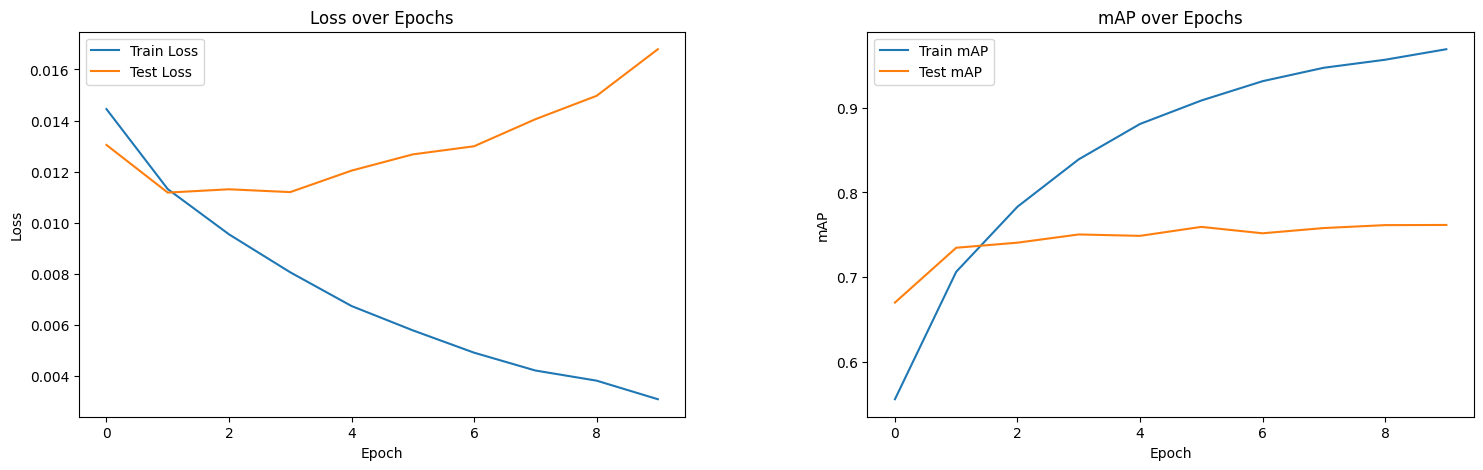

In [598]:
# Vẽ biểu đồ cho Loss
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Vẽ biểu đồ cho mAP
plt.subplot(1, 2, 2)
plt.plot(train_mAP_list, label='Train mAP')
plt.plot(test_mAP_list, label='Test mAP')
plt.title('mAP over Epochs')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.subplots_adjust(wspace=0.3)
plt.show()


<h4> Predict pizza image </h4>

In [604]:
def predict(img_tensor):
    img_tensor = img_tensor.unsqueeze(dim = 0)
    predicted = model(img_tensor)
    predicted = torch.round(predicted)
    print(predicted)

In [614]:
my_image_path = 'data/pizza_test_predict/6472fa11ba8c270029f74403.jpg'
my_image = Image.open(my_image_path)
my_image_tensor = transform(my_image)
predict(my_image_tensor)

tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<RoundBackward0>)
